GOAL : To predict the amount of electricity produced and consumed by Estonian energy customers who have installed solar panels. You'll have access to weather data, the relevant energy prices, and records of the installed photovoltaic capacity.

In [1]:
# General
import numpy as np
import pandas as pd

# visualiZation
import matplotlib.pyplot as plt
import seaborn as sns

# others
import json
import geopandas as gpd

# Mappings

## County_id to name

In [2]:
with open('../data/county_id_to_name_map.json', 'r') as f:
    data = json.load(f)
print(data)


{'0': 'HARJUMAA', '1': 'HIIUMAA', '2': 'IDA-VIRUMAA', '3': 'JÄRVAMAA', '4': 'JÕGEVAMAA', '5': 'LÄÄNE-VIRUMAA', '6': 'LÄÄNEMAA', '7': 'PÄRNUMAA', '8': 'PÕLVAMAA', '9': 'RAPLAMAA', '10': 'SAAREMAA', '11': 'TARTUMAA', '12': 'UNKNOWN', '13': 'VALGAMAA', '14': 'VILJANDIMAA', '15': 'VÕRUMAA'}


## train.csv

In [3]:
df_train = pd.read_csv('../data/train.csv')

df_train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60


About the dataset :

<b>county</b> - An ID code for the county.<br>
<b>is_business</b> - Boolean for whether or not the prosumer is a business.<br>
<b>product_type</b> - ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.<br>
<b>target</b> - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.<br>
<b>is_consumption</b> - Boolean for whether or not this row's target is consumption or production.<br>
<b>datetime</b> - The Estonian time in EET (UTC+2) / EEST (UTC+3). It describes the start of the 1-hour period on which target is given.<br>
<b>data_block_id</b> - All rows sharing the same data_block_id will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather data_block_id for predictins made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.<br>
<b>row_id</b> - A unique identifier for the row.<br>
<b>prediction_unit_id</b> - A unique identifier for the county, is_business, and product_type combination. New prediction units can appear or disappear in the test set.<br>

In [4]:
# missing values
df_train.isnull().sum()

county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

In [103]:
df_train = df_train.dropna(how='any')
df_train.shape

(2017824, 9)

## electricity_prices.csv

In [5]:
df_electricity = pd.read_csv('../data/electricity_prices.csv')
df_electricity

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1
...,...,...,...,...
15281,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,637
15282,2023-05-30 20:00:00,150.85,2023-05-29 20:00:00,637
15283,2023-05-30 21:00:00,82.10,2023-05-29 21:00:00,637
15284,2023-05-30 22:00:00,82.09,2023-05-29 22:00:00,637


## gas_prices.csv

In [6]:
df_gas = pd.read_csv('../data/gas_prices.csv')
df_gas

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5
...,...,...,...,...,...
632,2023-05-26,29.10,34.10,2023-05-25,633
633,2023-05-27,28.30,34.10,2023-05-26,634
634,2023-05-28,28.10,34.10,2023-05-27,635
635,2023-05-29,28.16,36.98,2023-05-28,636


## forecast_weather.csv

In [7]:
df_forecast_weather = pd.read_csv('../data/forecast_weather.csv')
df_forecast_weather

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424507,59.7,26.2,2023-05-30 02:00:00,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0
3424508,59.7,26.7,2023-05-30 02:00:00,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0
3424509,59.7,27.2,2023-05-30 02:00:00,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0
3424510,59.7,27.7,2023-05-30 02:00:00,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0


## historical_weather.csv

In [8]:
df_historical_weather = pd.read_csv('../data/historical_weather.csv')
df_historical_weather

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710797,2023-05-30 10:00:00,11.7,4.6,0.0,0.0,1018.9,40,9,54,0,1.055556,253,567.0,392.0,175.0,59.7,26.2,637.0
1710798,2023-05-30 10:00:00,12.3,3.5,0.0,0.0,1019.0,46,4,70,0,0.805556,263,581.0,407.0,174.0,59.7,26.7,637.0
1710799,2023-05-30 10:00:00,9.8,3.0,0.0,0.0,1019.2,41,4,62,0,1.972222,285,609.0,432.0,177.0,59.7,27.2,637.0
1710800,2023-05-30 10:00:00,11.7,1.6,0.0,0.0,1019.0,44,0,73,0,3.500000,307,658.0,521.0,137.0,59.7,27.7,637.0


## client.csv

This file gives information about all the clients of the estonian energy who have installed solar panels.

In [9]:
df_client = pd.read_csv('../data/client.csv')
df_client

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2
...,...,...,...,...,...,...,...
41914,1,15,51,415.60,0,2023-05-29,637
41915,3,15,161,2035.75,0,2023-05-29,637
41916,0,15,15,620.00,1,2023-05-29,637
41917,1,15,20,624.50,1,2023-05-29,637


# EDA 

### Some conclusions assumptions made

## Visualizations

In [41]:
df_gas['day_of_week'] = df_gas['forecast_date'].dt.day_name()
df_gas

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id,day_of_week
0,2021-09-01,45.23,46.32,2021-08-31,1,Wednesday
1,2021-09-02,45.62,46.29,2021-09-01,2,Thursday
2,2021-09-03,45.85,46.40,2021-09-02,3,Friday
3,2021-09-04,46.30,46.80,2021-09-03,4,Saturday
4,2021-09-05,46.30,46.58,2021-09-04,5,Sunday
...,...,...,...,...,...,...
632,2023-05-26,29.10,34.10,2023-05-25,633,Friday
633,2023-05-27,28.30,34.10,2023-05-26,634,Saturday
634,2023-05-28,28.10,34.10,2023-05-27,635,Sunday
635,2023-05-29,28.16,36.98,2023-05-28,636,Monday


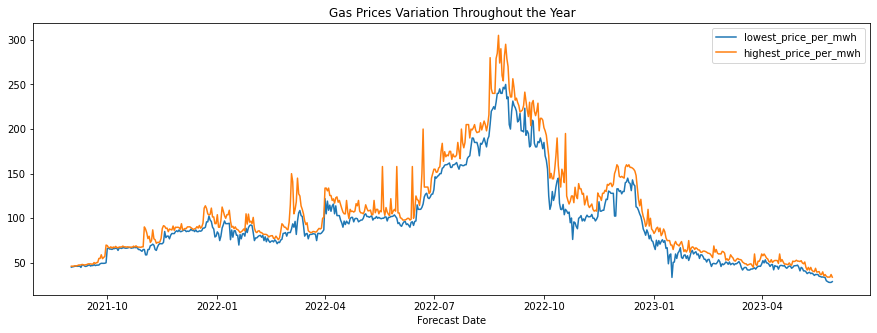

In [64]:
# Gas Prices :

# convert to datetime
df_gas['forecast_date'] = pd.to_datetime(df_gas['forecast_date'])
df_gas['origin_date'] = pd.to_datetime(df_gas['origin_date'])

# Filter data for year 2022
df_gas_2022 = df_gas[df_gas['forecast_date'].dt.year == 2022]

# df_gas['forecast_date']
plt.figure(figsize=(15, 5))  # Adjust figure size as desired
plt.plot(df_gas['forecast_date'], df_gas['lowest_price_per_mwh'], label = 'lowest_price_per_mwh')
plt.plot(df_gas['forecast_date'], df_gas['highest_price_per_mwh'], label = 'highest_price_per_mwh')
plt.xlabel('Forecast Date')
plt.title('Gas Prices Variation Throughout the Year')
plt.legend()

plt.show()

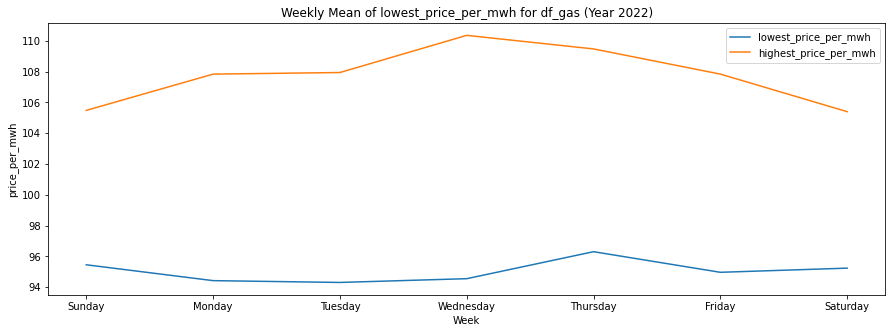

             lowest_price_per_mwh  highest_price_per_mwh  data_block_id
day_of_week                                                            
Sunday                  95.455495             105.477473          320.0
Monday                  94.426813             107.830549          321.0
Tuesday                 94.309560             107.934725          322.0
Wednesday               94.553846             110.347143          316.0
Thursday                96.305385             109.466484          317.0
Friday                  94.968242             107.831758          318.0
Saturday                95.237912             105.394286          319.0


In [59]:
# Resample by week and calculate mean (replace 'your_column_name' with the actual column)
weekly_mean = df_gas.groupby('day_of_week').mean()
# handling the days in rows from Monday to Sunday

weekly_mean = weekly_mean.reindex(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
# weekly_mean = df_gas.resample('W-SUN')['lowest_price_per_mwh'].mean()


# Plotting the weekly mean
plt.figure(figsize=(15, 5))  # Adjust figure size as desired
plt.plot(weekly_mean.index, weekly_mean['lowest_price_per_mwh'], label = 'lowest_price_per_mwh')
plt.plot(weekly_mean.index, weekly_mean['highest_price_per_mwh'], label = 'highest_price_per_mwh')

# Customize the plot for weeks (adjust labels accordingly)
plt.xlabel('Week')
plt.ylabel('price_per_mwh')
plt.title('Weekly Mean of lowest_price_per_mwh for df_gas (Year 2022)')  # Assuming data is for 2022
plt.legend()
plt.show()

print(weekly_mean)

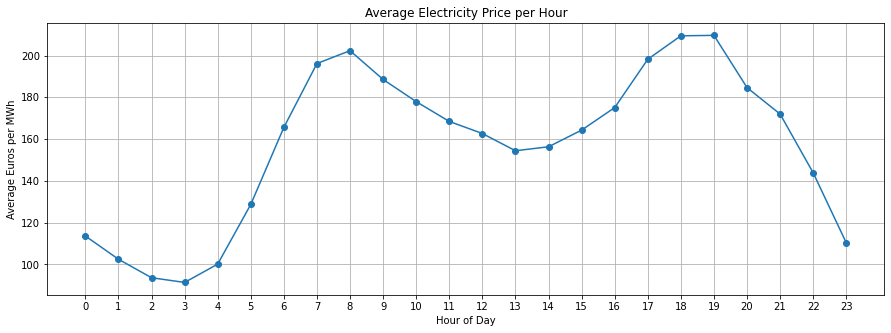

In [66]:
#Electrivity Prices

# Convert to datetime : 
df_electricity['forecast_date'] = pd.to_datetime(df_electricity['forecast_date'])
df_electricity['origin_date'] = pd.to_datetime(df_electricity['origin_date'])

# Extract the hour from the 'forecast_date' column
df_electricity['hour'] = df_electricity['forecast_date'].dt.hour

# Calculate average electricity price per hour
avg_price_per_hour = df_electricity.groupby('hour')['euros_per_mwh'].mean()
hours = avg_price_per_hour.index.to_numpy()  # Extract hours for the plot

# Create the plot
plt.figure(figsize=(15, 5))
plt.plot(hours, avg_price_per_hour.values, marker='o', linestyle='-')

# Customize the plot
plt.xlabel('Hour of Day')
plt.ylabel('Average Euros per MWh')
plt.title('Average Electricity Price per Hour')
plt.grid(True)
plt.xticks(range(24))  # Set x-axis ticks for all hours (0-23)

# Show the plot
plt.show()

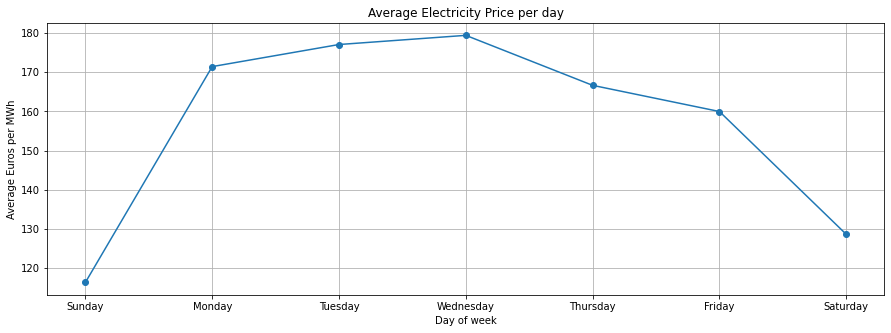

In [86]:
# Extract the hour from the 'forecast_date' column
df_electricity['day_of_week'] = df_electricity['forecast_date'].dt.day_name()
# df_electricity

# Calculate average electricity price per hour
avg_price_per_day = df_electricity.groupby('day_of_week')['euros_per_mwh'].mean()
avg_price_per_day = avg_price_per_day.reindex(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])

days_of_week = avg_price_per_day.index.to_numpy()  # Extract days for the plot

# avg_price_per_day
# Create the plot
plt.figure(figsize=(15, 5))
plt.plot(days_of_week, avg_price_per_day.values, marker='o', linestyle='-')

# # Customize the plot
plt.xlabel('Day of week')
plt.ylabel('Average Euros per MWh')
plt.title('Average Electricity Price per day')
plt.grid(True)
# plt.xticks(range(7))  # Set x-axis ticks for all hours (0-23)

# Show the plot
plt.show()

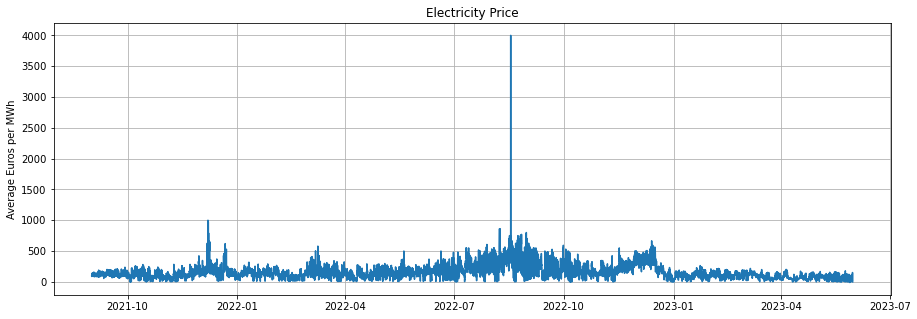

In [87]:
# electricity prices

# Create the plot
plt.figure(figsize=(15, 5))
plt.plot(df_electricity['forecast_date'], df_electricity['euros_per_mwh'])

# # Customize the plot
plt.ylabel('Average Euros per MWh')
plt.title('Electricity Price')
plt.grid(True)
# plt.xticks(range(7))  # Set x-axis ticks for all hours (0-23)

# Show the plot
plt.show()

It contains an outlier. Here is the boxplot for that outlier

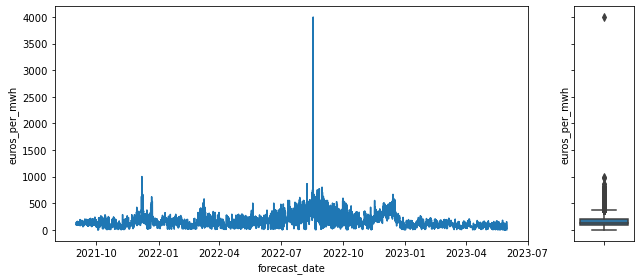

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [8, 1]}, sharey=True)
_ = sns.lineplot(x = df_electricity['forecast_date'], y = df_electricity['euros_per_mwh'], ax=axs[0])
_ = sns.boxplot(data = df_electricity, y = df_electricity['euros_per_mwh'], ax=axs[1])
fig.tight_layout()

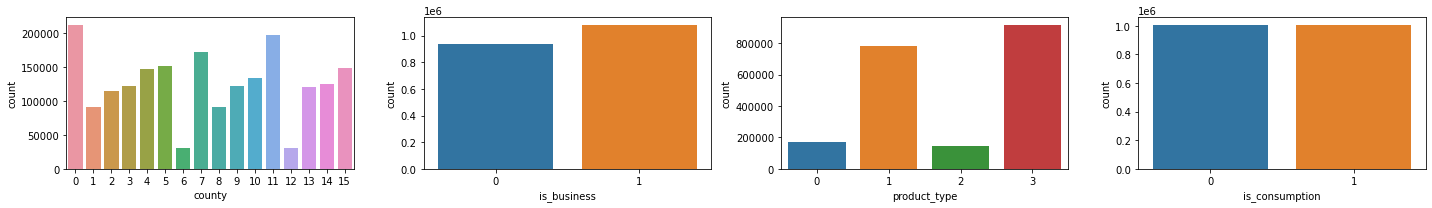

In [107]:
# counts for the county, business and product
columns = ['county','is_business','product_type','is_consumption']

fig, axs = plt.subplots(1, len(columns), figsize=(5*len(columns), 3))

for i, column in enumerate(columns):
    _ = sns.countplot(data = df_train, x=df_train[column], ax=axs[i])

_ = fig.tight_layout()

# Feature Engineering